<a href="https://colab.research.google.com/github/fatema373/Remove-EG-logo/blob/main/Logo_Removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fatema373/Remove-EG-logo.git

Cloning into 'Remove-EG-logo'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 64 (delta 18), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 19.65 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [2]:
!unzip -q /content/Remove-EG-logo/EFG.zip -d /content

# Imports


In [3]:
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import shutil
import cv2
import os

# Getting Yolov5 Ready

In [4]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16620, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 16620 (delta 55), reused 63 (delta 29), pack-reused 16522
Receiving objects: 100% (16620/16620), 15.15 MiB | 22.74 MiB/s, done.
Resolving deltas: 100% (11408/11408), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [5]:
# install dependencies as necessary

!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00
Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [6]:
%cd yolov5
# to run test images
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="cPQ6kWGIiH7WqtlNYtsR")
project = rf.workspace("cairo-university-vqdin").project("fine_tuned")
version = project.version(1)
dataset = version.download("yolov5")


[Errno 2] No such file or directory: 'yolov5'
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstal

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fine_tuned-1 in yolov5pytorch:: 100%|██████████| 296/296 [00:00<00:00, 8244.00it/s]


In [7]:
%cd /content/yolov5

/content/yolov5


In [8]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

## Cusomize Yolov5 params


In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## Helper functions

In [11]:
def read_first_line_and_split(filename):
    # Open the file in read mode
    with open(filename, 'r') as file:
        # Read the first line
        first_line = file.readline()

        # Split the first line into words using space as the delimiter
        words = first_line.split()
    return words
def get_coordinates(filename):
    list_ = read_first_line_and_split(filename)
    l = [float(i) for i in list_]
    print(l)
    x_center,y_center,width,height = l[1:]

    fixed_input_size = (640, 640)  # Example fixed input size
    image_width, image_height = fixed_input_size

    # Convert YOLOv5 output to coordinates (x1, y1, x2, y2)
    x1 = int((x_center - width / 2) * image_width)
    y1 = int((y_center - height / 2) * image_height)
    x2 = int((x_center + width / 2) * image_width)
    y2 = int((y_center + height / 2) * image_height)
    return x1,y1,x2,y2


In [12]:
def preprocess_image(image):
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape((-1, 3))

    # Convert to floating point
    pixels = np.float32(pixels)
    return pixels

def get_dominant_colors(pixels, k=3):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)

    # Retrieve the dominant colors
    colors = kmeans.cluster_centers_

    # Convert the pixel values to integer
    return colors.astype(int)

def display_dominant_colors(dominant_colors):
    # Create a blank white image
    bar = np.zeros((50, 300, 3), dtype=np.uint8)
    startX = 0

    # For each dominant color, draw a rectangle on the blank image
    for color in dominant_colors:
        endX = startX + (300 // len(dominant_colors))
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype(int).tolist(), -1)
        startX = endX

    # Display the image
    plt.imshow(bar)
    return

In [13]:
def delete_logo(in_img_path,out_img_path):

  image = cv2.imread(in_img_path)
  image = cv2.resize(image, (640,640))
  cv2.imwrite(in_img_path, image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.imshow(image)
  plt.show()

  # Detection
  !python detect.py --weights /content/EFG/weights/train/yolov5s_results2/weights/best.pt --img 640 --conf 0.6 --source {in_img_path} --save-txt

  print()
  txt_path = '/content/yolov5/runs/detect/exp/labels/'+os.path.basename(in_img_path[:-3]+'txt')
  print
  if os.path.exists(txt_path):
    x1,y1,x2,y2=get_coordinates(txt_path)

    # Crop the region of interest (ROI) from the image using the bounding box coordinates
    ROI = image[y1:y2,x1:x2]
    plt.imshow(ROI)
    plt.show()
    preprocessed_image = preprocess_image(ROI)
    num_colors = 5
    dominant_colors = get_dominant_colors(pixels=preprocessed_image, k=num_colors)

    display_dominant_colors(dominant_colors)
    lightenedcolor = [sum(i) for i in dominant_colors]
    ROI[:,:]=dominant_colors[np.argmax(lightenedcolor)]
    image[y1:y2, x1:x2] = ROI

    plt.imshow(image)
    plt.show()

    if not os.path.exists(out_img_path):
      os.makedirs(out_img_path)

    # Write the image to the output path
    output_image_path = os.path.join(out_img_path, os.path.basename(in_img_path))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_image_path, image)

  else:
    print('Yolo failed to detect')

  if os.path.exists('/content/yolov5/runs'):
    shutil.rmtree('/content/yolov5/runs')
  return


## Test images

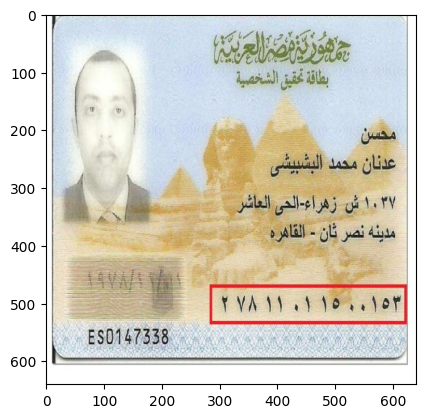

detect: weights=['/content/EFG/weights/train/yolov5s_results2/weights/best.pt'], source=/content/yolov5/fine_tuned-1/test/images/11_jpg.rf.c7cb800df15efdd1394b5270652f2939.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/yolov5/fine_tuned-1/test/images/11_jpg.rf.c7cb800df15efdd1394b5270652f2939.jpg: 640x640 1 logo-adzD, 12.5ms
Speed: 0.7ms pre-process, 12.5ms inference, 779.4ms NMS per image at shape (1, 3, 640,

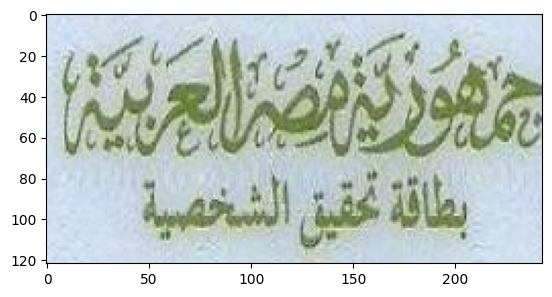

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


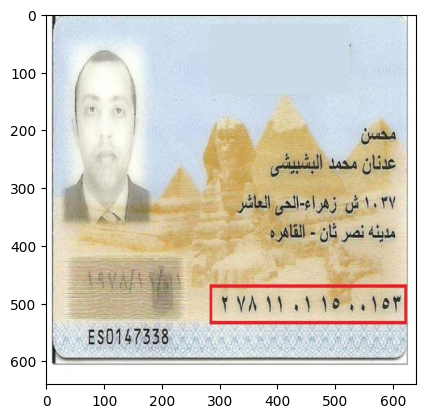

In [14]:
input_imag_path = '/content/yolov5/fine_tuned-1/test/images/11_jpg.rf.c7cb800df15efdd1394b5270652f2939.jpg'
out_path = '/content/EFG/out_path'
delete_logo(input_imag_path,out_path)

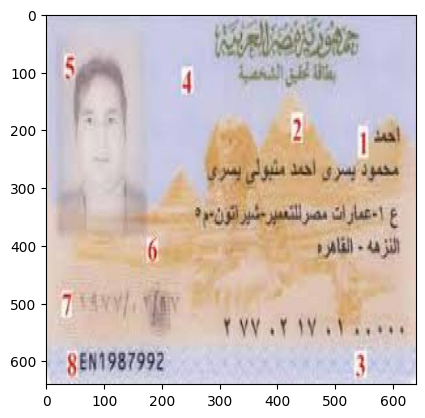

detect: weights=['/content/EFG/weights/train/yolov5s_results2/weights/best.pt'], source=/content/yolov5/fine_tuned-1/test/images/57_jpg.rf.960573249975f647dd902a042fe48d87.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/yolov5/fine_tuned-1/test/images/57_jpg.rf.960573249975f647dd902a042fe48d87.jpg: 640x640 1 logo-adzD, 12.6ms
Speed: 0.6ms pre-process, 12.6ms inference, 870.2ms NMS per image at shape (1, 3, 640,

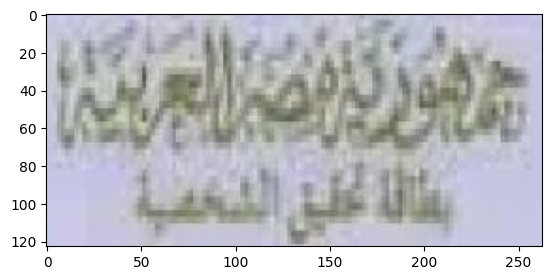

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


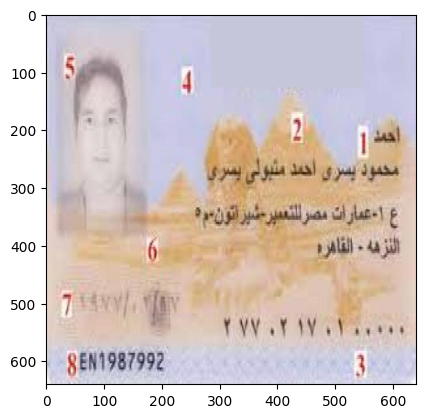

In [15]:
input_imag_path = '/content/yolov5/fine_tuned-1/test/images/57_jpg.rf.960573249975f647dd902a042fe48d87.jpg'
out_path = '/content/EFG/out_path'
delete_logo(input_imag_path,out_path)

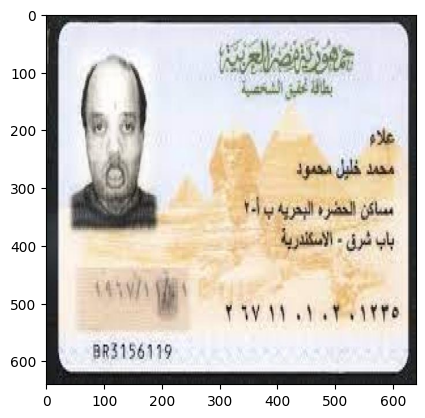

detect: weights=['/content/EFG/weights/train/yolov5s_results2/weights/best.pt'], source=/content/yolov5/fine_tuned-1/test/images/25_jpg.rf.1e4847356e1fdb85287c5ab4d5a4fd59.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/yolov5/fine_tuned-1/test/images/25_jpg.rf.1e4847356e1fdb85287c5ab4d5a4fd59.jpg: 640x640 1 logo-adzD, 12.5ms
Speed: 0.6ms pre-process, 12.5ms inference, 640.8ms NMS per image at shape (1, 3, 640,

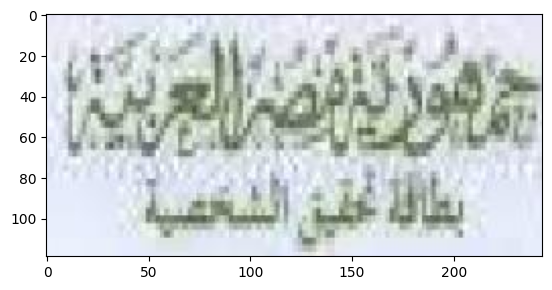

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


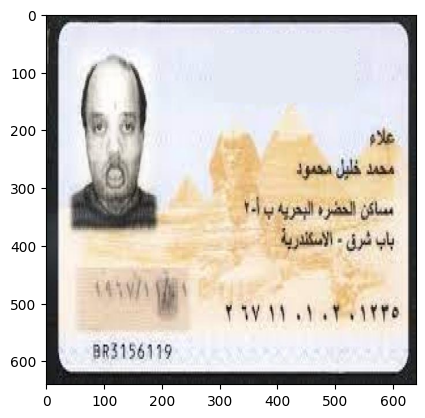

In [16]:
input_imag_path = '/content/yolov5/fine_tuned-1/test/images/25_jpg.rf.1e4847356e1fdb85287c5ab4d5a4fd59.jpg'
out_path = '/content/EFG/out_path'
delete_logo(input_imag_path,out_path)